#### Reference
https://www.kaggle.com/joaopmpeinado/talkingdata-xgboost-lb-0-966/code

In [66]:
import gc
import time
import numpy as np
import pandas as pd
from sklearn.cross_validation import train_test_split
import xgboost as xgb
from xgboost import plot_importance

import warnings
warnings.filterwarnings('ignore')
import os
import matplotlib.pyplot as plt
%matplotlib inline
path = '../../../DEVELOPMENT/Fraud Detection/input/'

dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

In [67]:
start_time = time.time()

In [68]:
train_columns = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed']
test_columns  = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'click_id']
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

# Read the last lines because they are more impacting in training than the starting lines
train = pd.read_csv(path+"train_sample.csv", usecols=train_columns, dtype=dtypes)
test = pd.read_csv(path+"test.csv", usecols=test_columns, dtype=dtypes)
print('[{}] Finished to load data'.format(time.time() - start_time))

[17.705703020095825] Finished to load data


In [69]:
# Drop the IP and the columns from target
y = train['is_attributed']
train.drop(['is_attributed'], axis=1, inplace=True)

# Drop IP and ID from test rows
sub = pd.DataFrame()
#sub['click_id'] = test['click_id'].astype('int')
test.drop(['click_id'], axis=1, inplace=True)
gc.collect()

nrow_train = train.shape[0]
merge = pd.concat([train, test])

del train, test
gc.collect()

0

In [70]:
def prep_data(d): 
    
    d['datetime'] = pd.to_datetime(d['click_time'])
    d['hour'] = pd.to_datetime(d.click_time).dt.hour.astype('uint8')
    d['day'] = pd.to_datetime(d.click_time).dt.day.astype('uint8')
    d['wday']  = pd.to_datetime(d.click_time).dt.dayofweek.astype('uint8')

    print('grouping by ip-day-hour combination')
    
    gp = d[['ip','day','hour','channel']].groupby(by=['ip','day','hour'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip-day-hour'})
    d = d.merge(gp, on=['ip','day','hour'], how='left')
    del gp; gc.collect()
    
    print('group by ip-app combination')
    gp = d[['ip','app', 'channel']].groupby(by=['ip', 'app'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app_count'})
    d = d.merge(gp, on=['ip','app'], how='left')
    del gp; gc.collect()
    
    print('group by ip-app-os combination')
    gp = d[['ip','app', 'os', 'channel']].groupby(by=['ip', 'app', 'os'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app_os_count'})
    d = d.merge(gp, on=['ip','app', 'os'], how='left')
    del gp; gc.collect()
    
    print("vars and data type")
    d['ip-day-hour'] = d['ip-day-hour'].astype('uint16')
    d['ip_app_count'] = d['ip_app_count'].astype('uint16')
    d['ip_app_os_count'] = d['ip_app_os_count'].astype('uint16')
    
    print("label encoding....")
    from sklearn.preprocessing import LabelEncoder
    d[['app','device','os', 'channel', 'hour', 'day', 'wday']].apply(LabelEncoder().fit_transform)
    print('dropping')
    d.drop(['click_time', 'datetime','ip'], 1, inplace=True)

    return d

In [71]:
merge = prep_data(merge)

grouping by ip-day-hour combination
group by ip-app combination
group by ip-app-os combination
vars and data type
label encoding....
dropping


In [72]:
train = merge[:nrow_train]
test = merge[nrow_train:]

del test, merge
gc.collect()

train.head()

,app,device,os,channel,hour,day,wday,ip-day-hour,ip_app_count,ip_app_os_count
0,12,1,13,497,9,7,1,1,152,44
1,25,1,17,259,13,7,1,4,25,1
2,12,1,19,212,18,7,1,1,31,13
3,13,1,13,477,4,7,1,1,17,2
4,12,1,1,178,9,9,3,1,166,3


In [73]:
# Set the params(this params from Pranav kernel) for xgboost model
params = {'eta': 0.3,
          'tree_method': "hist",
          'grow_policy': "lossguide",
          'max_leaves': 1400,  
          'max_depth': 0, 
          'subsample': 0.9, 
          'colsample_bytree': 0.7, 
          'colsample_bylevel':0.7,
          'min_child_weight':0,
          'alpha':4,
          'objective': 'binary:logistic', 
          'scale_pos_weight':9,
          'eval_metric': 'auc', 
          'nthread':8,
          'random_state': 99, 
          'silent': True}

In [74]:
# Change this for validation with 10% from train
is_valid = False

In [75]:
if (is_valid == True):
    # Get 10% of train dataset to use as validation
    x1, x2, y1, y2 = train_test_split(train, y, test_size=0.1, random_state=99)
    dtrain = xgb.DMatrix(x1, y1)
    dvalid = xgb.DMatrix(x2, y2)
    del x1, y1, x2, y2 
    gc.collect()
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
    model = xgb.train(params, dtrain, 200, watchlist, maximize=True, early_stopping_rounds = 25, verbose_eval=5)
    del dvalid
else:
    dtrain = xgb.DMatrix(train, y)
    del train, y
    gc.collect()
    watchlist = [(dtrain, 'train')]
    model = xgb.train(params, dtrain, 30, watchlist, maximize=True, verbose_eval=1)

del dtrain
gc.collect()

print('[{}] Finish XGBoost Training'.format(time.time() - start_time))

[0]	train-auc:0.934326
[1]	train-auc:0.94676
[2]	train-auc:0.94701
[3]	train-auc:0.950831
[4]	train-auc:0.951007
[5]	train-auc:0.953381
[6]	train-auc:0.957481
[7]	train-auc:0.965966
[8]	train-auc:0.968264
[9]	train-auc:0.968166
[10]	train-auc:0.970517
[11]	train-auc:0.978797
[12]	train-auc:0.98039
[13]	train-auc:0.986604
[14]	train-auc:0.995968
[15]	train-auc:0.995806
[16]	train-auc:0.999183
[17]	train-auc:0.999407
[18]	train-auc:0.999426
[19]	train-auc:0.999583
[20]	train-auc:0.999628
[21]	train-auc:0.999652
[22]	train-auc:0.999681
[23]	train-auc:0.999713
[24]	train-auc:0.999728
[25]	train-auc:0.99973
[26]	train-auc:0.999767
[27]	train-auc:0.999791
[28]	train-auc:0.999805
[29]	train-auc:0.999819
[142.6064510345459] Finish XGBoost Training


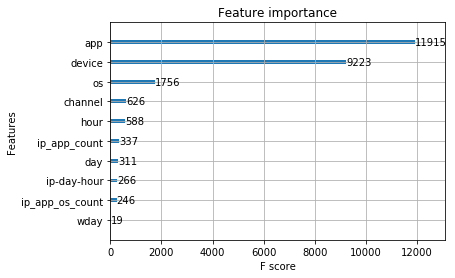

In [76]:
# Plot the feature importance from xgboost
plot_importance(model)
plt.gcf().savefig('feature_importance_xgb.png')

In [77]:
# Load the test for predict 
test = pd.read_csv(path+"test.csv", usecols=test_columns, dtype=dtypes)
test = prep_data(test)
gc.collect()

grouping by ip-day-hour combination
group by ip-app combination
group by ip-app-os combination
vars and data type
label encoding....
dropping


66

In [78]:
test.tail()

,click_id,app,device,os,channel,hour,day,wday,ip-day-hour,ip_app_count,ip_app_os_count
18790464,18790464,9,1,13,127,15,10,4,2,16,3
18790465,18790465,23,1,37,153,15,10,4,1,30,2
18790466,18790467,18,1,17,265,15,10,4,2,190,7
18790467,18790466,27,1,13,122,15,10,4,1,1,1
18790468,18790468,12,2,27,265,15,10,4,4,14704,94


In [79]:
sub['click_id'] = test['click_id'].astype('int')
test.drop(['click_id'], axis=1, inplace=True)

In [80]:
dtest = xgb.DMatrix(test)
del test
gc.collect()

# Save the predictions
sub['is_attributed'] = model.predict(dtest, ntree_limit=model.best_ntree_limit)
sub.to_csv('Sol8_xgb_sub.csv', float_format='%.8f', index=False)